# Proyecto Final

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Conjunto de datos

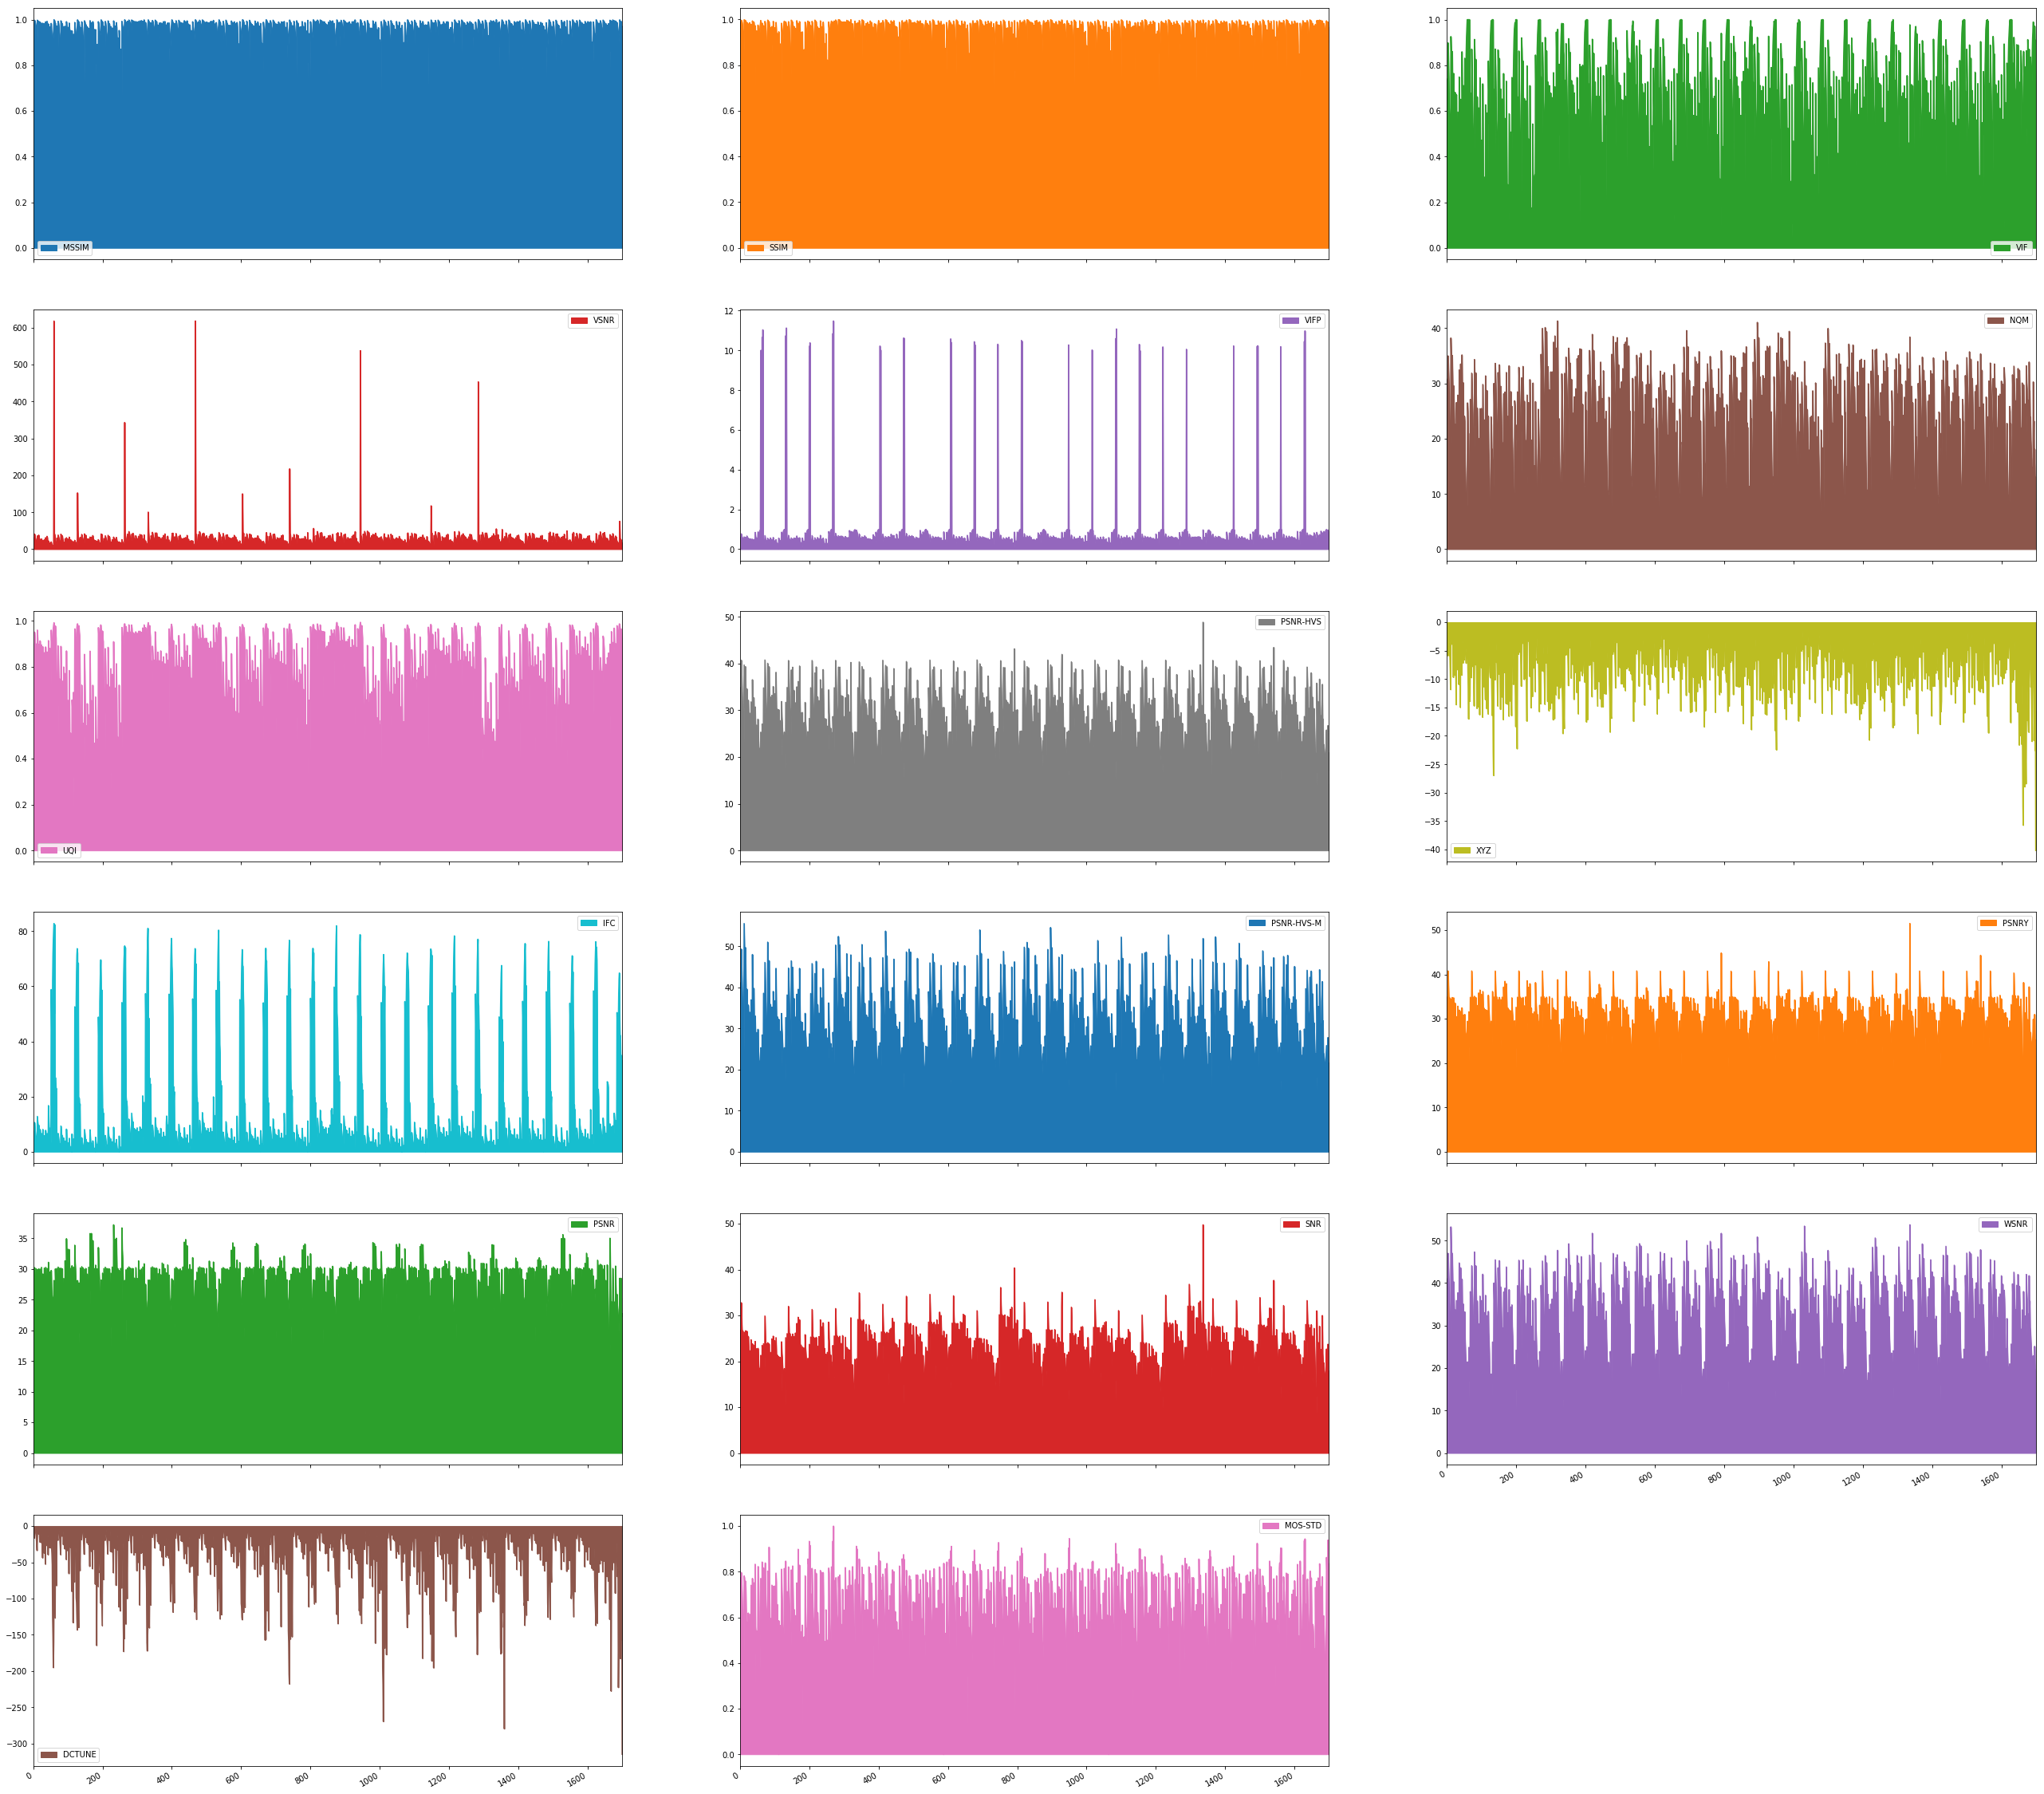

In [4]:
datasetFile = "dataset.csv"
dataFrame = pd.read_csv(datasetFile, sep = ';',header = 0)

# Remove the non-numeric columns
dataFrame = dataFrame._get_numeric_data()
dataFrame = dataFrame.dropna(axis='columns')

# Drop unneeded features
dataFrame = dataFrame.drop('MOS', 1)

# Get the numeric headers in a python list
numericHeaders = list(dataFrame.columns.values)

# Get a numpy array
npData = dataFrame.values

# Plot the raw data
plt.rcParams["figure.figsize"]=45,45
dataFrame.plot(kind='area', subplots=True, layout=(6,3))
plt.show()

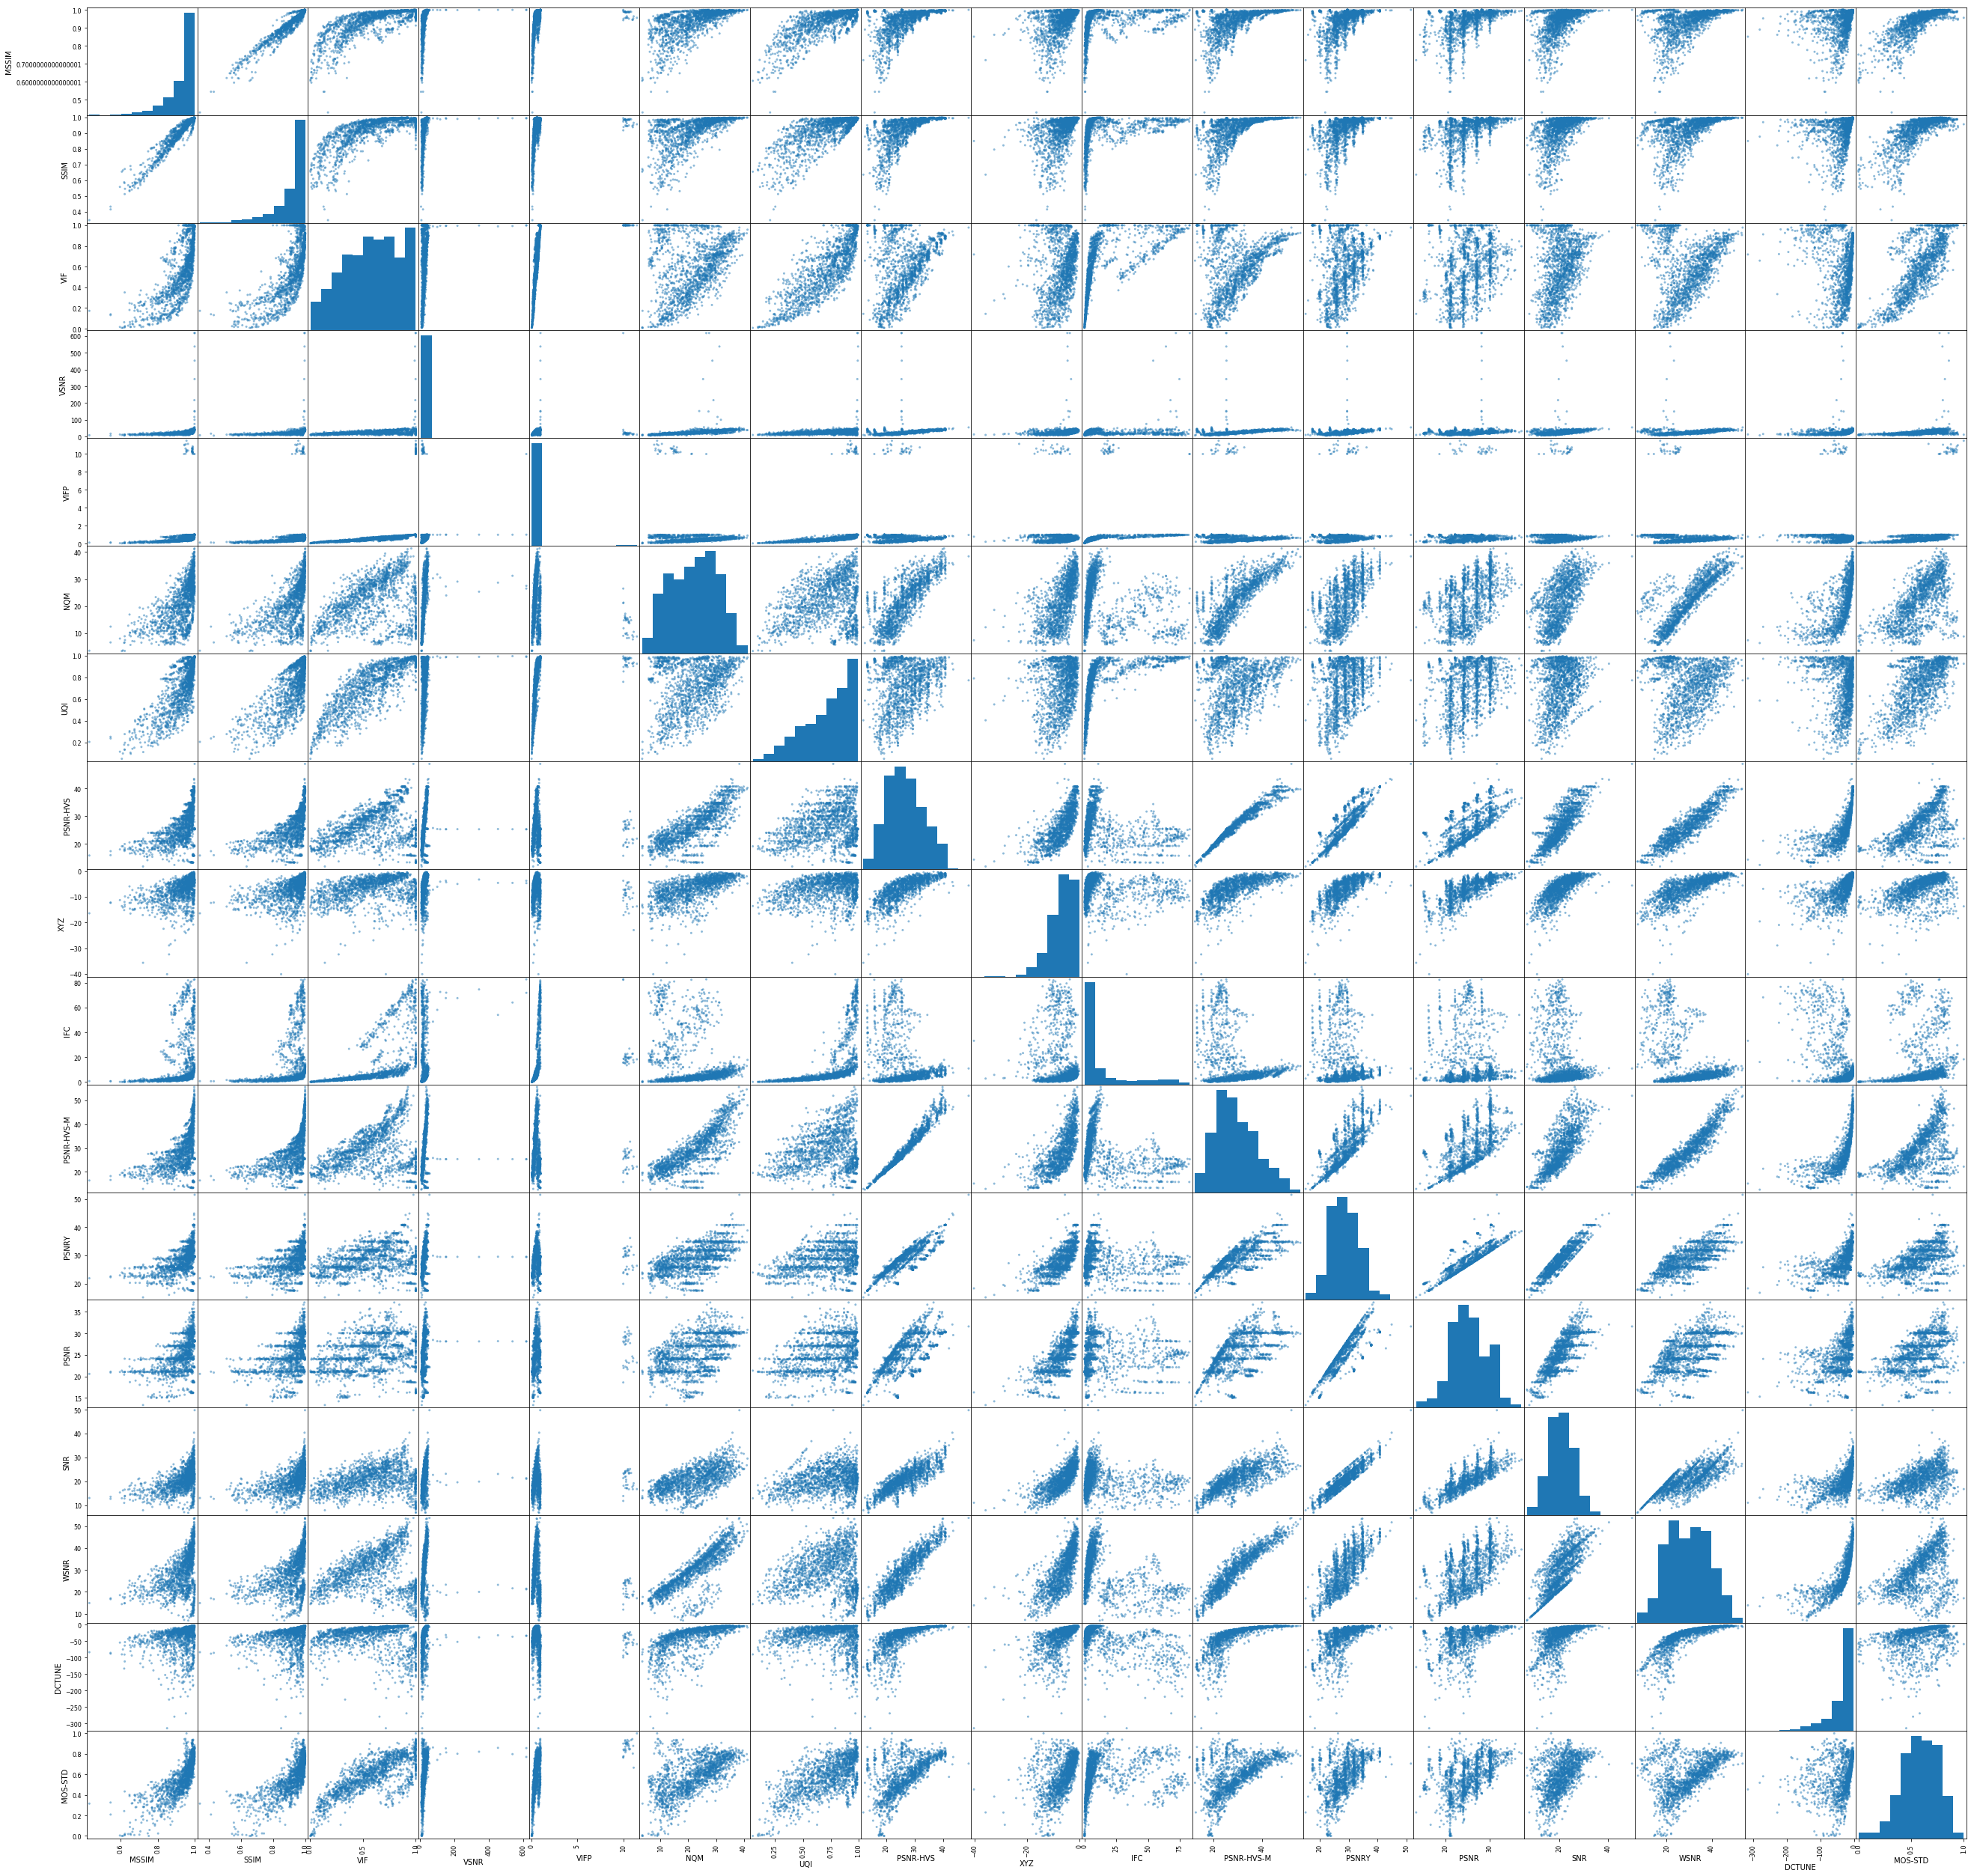

In [5]:
scatter_matrix(dataFrame)
plt.show()

In [6]:
for metric in numericHeaders:
    mean, std = dataFrame[metric].mean(), dataFrame[metric].std()
    outliers = (dataFrame[metric] - mean).abs() > 3*std
    dataFrame[metric][outliers] = mean

In [7]:
from sklearn import preprocessing

# Normilize the following metrics
normMetrics = ['VSNR','VIFP','NQM','XYZ','PSNR-HVS','IFC','PSNR-HVS-M','PSNRY','WSNR','SNR','PSNR','DCTUNE']
normFrame = dataFrame[normMetrics]
dataFrame[normMetrics] = preprocessing.normalize(dataFrame[normMetrics], norm='l2')

## Dividir el conjunto de datos

In [8]:
# Split the data
train = dataFrame.sample(frac = 0.7, random_state = 200)
test = dataFrame.drop(train.index)

# Set the feature and target datasets
X_train = train.loc[:,numericHeaders[0]:numericHeaders[len(numericHeaders) - 2]]
Y_train = train["MOS-STD"]
X_test = test.loc[:,numericHeaders[0]:numericHeaders[len(numericHeaders) - 2]]
Y_test = test["MOS-STD"]

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1190 train samples
510 test samples


## Arquitectura de la red neuronal

In [16]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K

model = Sequential()

model.add(Dense(128, input_dim=16))
model.add(Activation('relu'))
#model.add(Dropout(.3))

model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    
# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento del modelo

In [32]:
# Training the model
history = model.fit(X_train, Y_train, epochs=5000, batch_size=100, validation_split=0.25, verbose=0)

## Verificación del modelo

In [33]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, Y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, Y_test)
print("\n Testing Accuracy:", score[1])

1190/1190 [==============================] - 0s 52us/step

 Training Accuracy: 0.941408660331694
510/510 [==============================] - 0s 62us/step

 Testing Accuracy: 0.8150326862054713


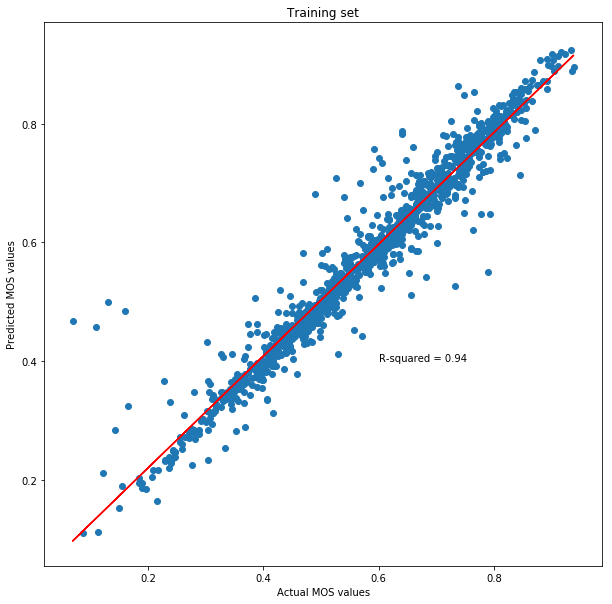

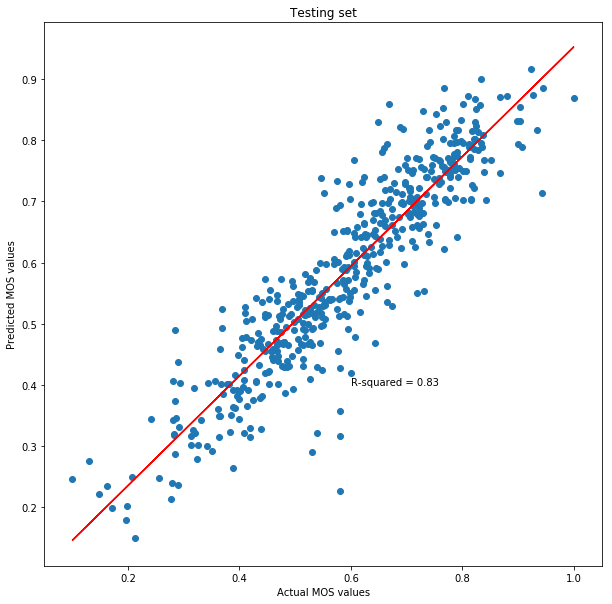

In [42]:
from sklearn.metrics import r2_score

def plot_metric(group, output, title):
    y_test = output.values
    Y_pred = model.predict(group)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')

    params = {
        'figure.figsize': (10, 10)
    }
    plt.rcParams.update(params)
    plt.text(0.6, 0.4, 'R-squared = %0.2f' % r_squared)
    plt.show()
    
plot_metric(X_train, Y_train, 'Training set')
plot_metric(X_test, Y_test, 'Testing set')

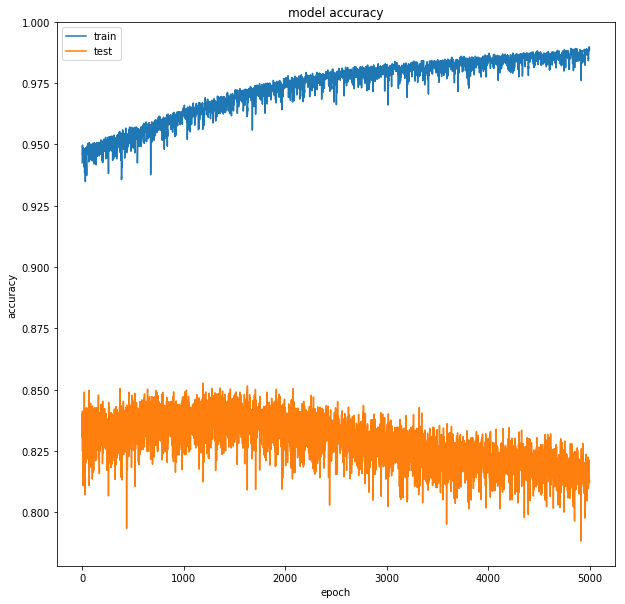

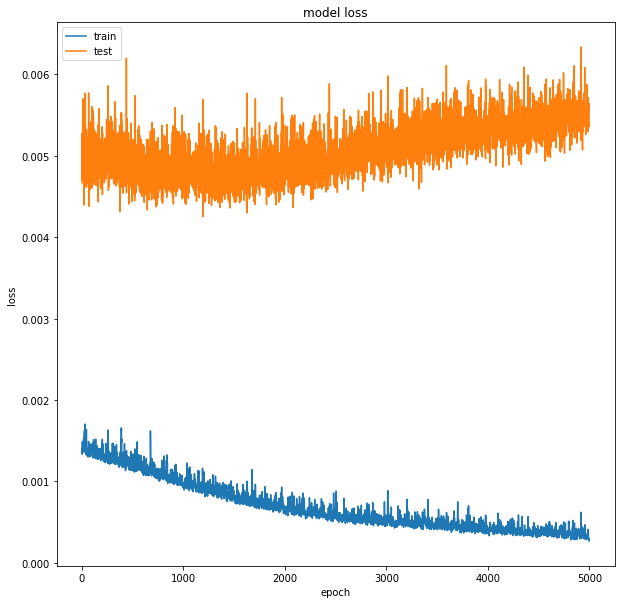

In [41]:
# summarize history for accuracy
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()